## Finding the MRI  brain tumor detection dataset

### Finding the MRI  brain tumor detection dataset

we have to find the  MRI  brain tumor detection dataset from kaggle.

In [1]:
# install opencv
!pip install opencv-python-headless

# importing libraries
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tumor = []


# Path can match .jpg, .JPG, .jpeg, and .JPEG files
path = 'data/brain_tumor_dataset/yes/*.[jJ][pP][gG]'

for i in glob.iglob(path):
    img = cv2.imread(i);
    img = cv2.resize(img,(128,128))
    b,g,r = cv2.split(img)
    img =cv2.merge([r,g,b])
    tumor.append(img)

In [3]:
healthy = []
# Path can match .jpg, .JPG, .jpeg, and .JPEG files
path = 'data/brain_tumor_dataset/no/*.[jJ][pP][gG]'

for i in glob.iglob(path):
    img = cv2.imread(i);
    img = cv2.resize(img,(128,128))
    b,g,r = cv2.split(img)
    img =cv2.merge([r,g,b])
    healthy.append(img)

In [4]:
# converting the tumor and healthy to numpy array

healthy = np.array(healthy)
tumor = np.array(tumor)

In [5]:
len(healthy),len(tumor)

(91, 154)

## Prepare our model to train

In [27]:
from sklearn.model_selection import train_test_split

# Create labels
labels_tumor = np.ones(len(tumor))
labels_healthy = np.zeros(len(healthy))

# Combine data and labels
X = np.concatenate((tumor, healthy), axis=0)
y = np.concatenate((labels_tumor, labels_healthy), axis=0)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## create a dataset class

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create train and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Batch and shuffle the datasets
BATCH_SIZE = 16  # Adjusted batch size
BUFFER_SIZE = 100  # Adjusted buffer size

train_dataset = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

## Build the model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# compile the model

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the model

In [40]:
import time

start_time = time.time()
history = model.fit(train_dataset, epochs=25, validation_data=val_dataset)
end_time = time.time()

time_per_epoch = end_time - start_time
print(f"Time per epoch: {time_per_epoch} seconds")

Epoch 1/25
13/13 [==============================] - 10s 750ms/step - loss: 0.6746 - accuracy: 0.7143 - val_loss: 0.7090 - val_accuracy: 0.6939
Epoch 2/25
13/13 [==============================] - 10s 750ms/step - loss: 0.5531 - accuracy: 0.7551 - val_loss: 0.7516 - val_accuracy: 0.6735
Epoch 3/25
13/13 [==============================] - 10s 750ms/step - loss: 0.6322 - accuracy: 0.7704 - val_loss: 0.8579 - val_accuracy: 0.6939
Epoch 4/25
13/13 [==============================] - 10s 759ms/step - loss: 0.4838 - accuracy: 0.7959 - val_loss: 1.0243 - val_accuracy: 0.6122
Epoch 5/25
13/13 [==============================] - 10s 750ms/step - loss: 0.6363 - accuracy: 0.7551 - val_loss: 1.3964 - val_accuracy: 0.5102
Epoch 6/25
13/13 [==============================] - 10s 743ms/step - loss: 0.7618 - accuracy: 0.7653 - val_loss: 1.4971 - val_accuracy: 0.5306
Epoch 7/25
13/13 [==============================] - 10s 742ms/step - loss: 0.7597 - accuracy: 0.7296 - val_loss: 0.6518 - val_accuracy: 0.7143

## evaluate the model

In [41]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

4/4 [==============================] - 0s 101ms/step - loss: 1.8484 - accuracy: 0.7347
Validation Loss: 1.8484050035476685
Validation Accuracy: 0.7346938848495483


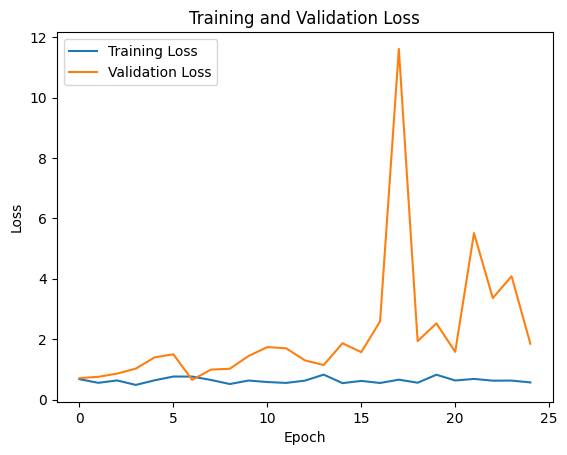

In [42]:
# let's view the result  in confusion matrix and other parameters

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 193ms/step


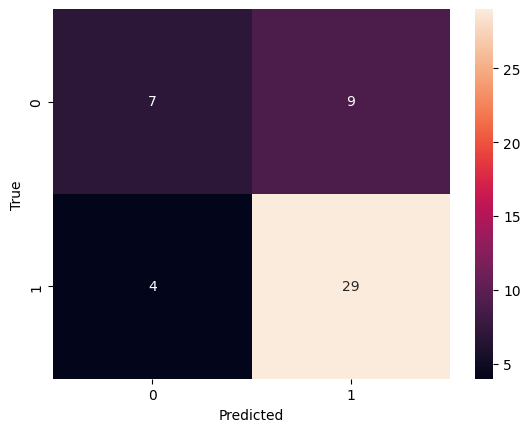

In [43]:
# code to view the confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)
y_pred = np.round(y_pred)

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [44]:
# code to view the f1 score

from sklearn.metrics import f1_score
f1 = f1_score(y_val, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8169014084507042


In [45]:
# let's view the classification report

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.44      0.52        16
         1.0       0.76      0.88      0.82        33

    accuracy                           0.73        49
   macro avg       0.70      0.66      0.67        49
weighted avg       0.72      0.73      0.72        49



4/4 [==============================] - 0s 106ms/step


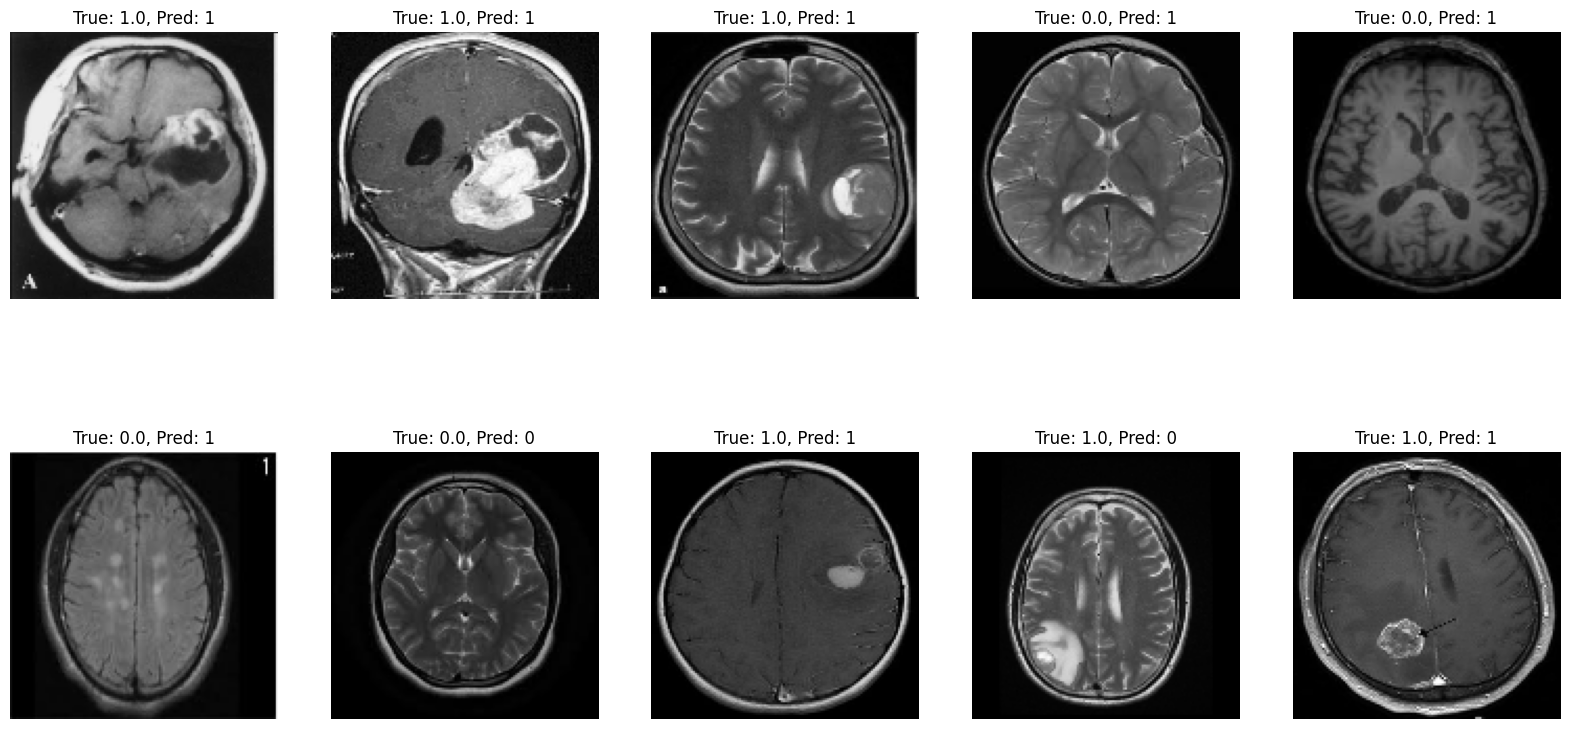

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_test and y_test are your test data and labels
# Convert to TensorFlow dataset
BATCH_SIZE = 16  # Adjust batch size as needed
test_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

# Make predictions
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

# Function to display images with predictions and actual labels
def display_images_with_predictions(images, true_labels, predicted_labels, num_images=20):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

# Get a batch of test images and labels
test_images, test_labels = next(iter(test_dataset.unbatch().batch(len(X_val))))

# Display the images with predictions and actual labels
display_images_with_predictions(test_images.numpy(), test_labels.numpy(), predicted_labels, num_images=10)

In [49]:
# checking the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, predicted_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7346938775510204


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68a75c25-247a-43d2-b111-303d7c427653' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>